# Random Forest for EEG + Spectrogram

In [1]:
import pandas as pd
import CONSTANT

df = pd.read_csv(CONSTANT.PATH_TO_TRAIN_CSV)

vote_cols = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]

# Normalize the votes to get probabilities
df["total_votes"] = df[vote_cols].sum(axis=1)
for col in vote_cols:
    df[col + "_prob"] = df[col] / df["total_votes"]

# Keep only needed columns
final_df = df[["eeg_id", "spectrogram_id", "expert_consensus"] + [col + "_prob" for col in vote_cols]]

# Drop duplicate eeg_ids — keep the first
# final_df = final_df.drop_duplicates(subset="eeg_id", keep="first")

# Save to new CSV
final_df.to_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/random_forest_saved_data/eeg_spect_vote_probs_grouped.csv", index=False)

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# Feature extraction from each EEG .parquet file
def extract_features_from_parquet_eeg(parquet_path_eeg):
    df = pd.read_parquet(parquet_path_eeg, columns=["Fp1", "O1", "O2", "Fp2"])

    features_eeg = {}
    for col in ["Fp1", "O1", "O2", "Fp2"]:
        features_eeg[f"{col}_median"] = df[col].median()
        features_eeg[f"{col}_std"] = df[col].std()
        features_eeg[f"{col}_min"] = df[col].min()
        features_eeg[f"{col}_max"] = df[col].max()
    return features_eeg

In [4]:
def extract_features_from_parquet_spect(parquet_path_spect):
    df = pd.read_parquet(parquet_path_spect)
    groups = ['LL', 'RL', 'LP', 'RP']
    features_spect = {}
    for group in groups:
        group_cols = [col for col in df.columns if col.startswith(group)]
        group_values = df[group_cols].values.flatten()
        
        # Compute stats across all group values
        features_spect[f"{group}_median"] = pd.Series(group_values).median()
        features_spect[f"{group}_std"] = pd.Series(group_values).std()
        features_spect[f"{group}_min"] = pd.Series(group_values).min()
        features_spect[f"{group}_max"] = pd.Series(group_values).max()

    
    return features_spect

In [5]:
# Load the CSV
meta_df = pd.read_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/random_forest_saved_data/eeg_spect_vote_probs_grouped.csv")

# Map expert consensus to integer labels
label_map = {label: i for i, label in enumerate(meta_df['expert_consensus'].unique())}
meta_df['label'] = meta_df['expert_consensus'].map(label_map)

In [6]:
import pandas as pd

# Load the entire Parquet file (or just the metadata)
df = pd.read_parquet(CONSTANT.PATH_TO_FILES_TRAIN_SPECT+'/353733.parquet')

# Print all available features (column names)
print("Available columns/features:")
print(df.columns.tolist())

Available columns/features:
['time', 'LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34', 'LL_2.54', 'LL_2.73', 'LL_2.93', 'LL_3.13', 'LL_3.32', 'LL_3.52', 'LL_3.71', 'LL_3.91', 'LL_4.1', 'LL_4.3', 'LL_4.49', 'LL_4.69', 'LL_4.88', 'LL_5.08', 'LL_5.27', 'LL_5.47', 'LL_5.66', 'LL_5.86', 'LL_6.05', 'LL_6.25', 'LL_6.45', 'LL_6.64', 'LL_6.84', 'LL_7.03', 'LL_7.23', 'LL_7.42', 'LL_7.62', 'LL_7.81', 'LL_8.01', 'LL_8.2', 'LL_8.4', 'LL_8.59', 'LL_8.79', 'LL_8.98', 'LL_9.18', 'LL_9.38', 'LL_9.57', 'LL_9.77', 'LL_9.96', 'LL_10.16', 'LL_10.35', 'LL_10.55', 'LL_10.74', 'LL_10.94', 'LL_11.13', 'LL_11.33', 'LL_11.52', 'LL_11.72', 'LL_11.91', 'LL_12.11', 'LL_12.3', 'LL_12.5', 'LL_12.7', 'LL_12.89', 'LL_13.09', 'LL_13.28', 'LL_13.48', 'LL_13.67', 'LL_13.87', 'LL_14.06', 'LL_14.26', 'LL_14.45', 'LL_14.65', 'LL_14.84', 'LL_15.04', 'LL_15.23', 'LL_15.43', 'LL_15.63', 'LL_15.82', 'LL_16.02', 'LL_16.21', 'LL_16.41', 'LL_16.6', 'LL_16.8', 'LL_16.99', '

In [12]:
from tqdm import tqdm
def process_row(row):
    eeg_id = row["eeg_id"]
    spect_id = row["spectrogram_id"]
    label = row["label"]

    try:
        eeg_path = f"{CONSTANT.PATH_TO_FILES_TRAIN_EEG}/{eeg_id}.parquet"
        spect_path = f"{CONSTANT.PATH_TO_FILES_TRAIN_SPECT}/{spect_id}.parquet"

        eeg_features = extract_features_from_parquet_eeg(eeg_path)
        spect_features = extract_features_from_parquet_spect(spect_path)

        combined = {**eeg_features, **spect_features}
        return combined, label

    except FileNotFoundError as e:
        print(f"Missing file: {e}")
        return None, None
    except Exception as e:
        print(f"Error processing row (EEG {eeg_id}, SPECT {spect_id}): {e}")
        return None, None


data, labels = [], []

for _, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Processing EEG+SPECT"):
    features, label = process_row(row)
    if features is not None:
        data.append(features)
        labels.append(label)


Processing EEG+SPECT: 100%|██████████| 106800/106800 [2:49:50<00:00, 10.48it/s]   


In [ ]:
features_df = pd.DataFrame(data)

In [14]:
features_df.to_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/eeg_spect_dataset.csv", index=False)
print("CSV saved to eeg_spect_dataset.csv")

CSV saved to eeg_spect_dataset.csv


In [22]:
df = pd.read_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/eeg_spect_dataset.csv")

# Define feature columns (exclude label)
feature_cols = [
    'Fp1_median','Fp1_std','Fp1_min','Fp1_max',
    'O1_median','O1_std','O1_min','O1_max',
    'O2_median','O2_std','O2_min','O2_max',
    'Fp2_median','Fp2_std','Fp2_min','Fp2_max',
    'LL_median','LL_std','LL_min','LL_max',
    'RL_median','RL_std','RL_min','RL_max',
    'LP_median','LP_std','LP_min','LP_max',
    'RP_median','RP_std','RP_min','RP_max'
]

In [23]:
X = df[feature_cols]
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# Predictions
y_pred = model.predict(X_test)

In [33]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9457397003745318

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      4165
           1       0.97      0.97      0.97      3444
           2       0.95      0.97      0.96      3375
           3       0.93      0.91      0.92      3757
           4       0.98      0.97      0.98      3709
           5       0.90      0.93      0.91      2910

    accuracy                           0.95     21360
   macro avg       0.94      0.95      0.95     21360
weighted avg       0.95      0.95      0.95     21360



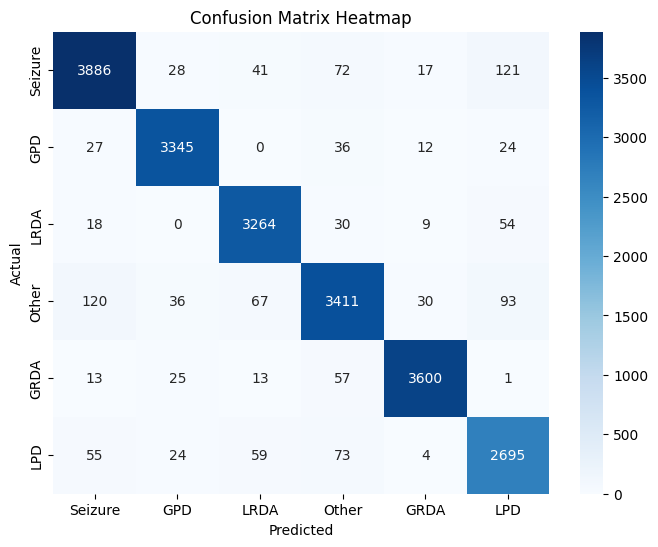

In [34]:
# === Confusion Matrix ===
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

# Optional: Class names for labeling
class_names = [k for k, v in sorted(label_map.items(), key=lambda x: x[1])]

# === Plot Heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [27]:
eeg_path = "/Users/Patron/Documents/brain-waves-classification/hms_data/test_eegs/3911565283.parquet"
spect_path = "/Users/Patron/Documents/brain-waves-classification/hms_data/test_spectrograms/853520.parquet"

eeg_features = extract_features_from_parquet_eeg(eeg_path)
spect_features = extract_features_from_parquet_spect(spect_path)

In [28]:
# Combine them into a single dict
combined_features = {**eeg_features, **spect_features}

In [29]:
test_df = pd.DataFrame([combined_features])  # list of dicts => 1 row

In [30]:
predicted_label = model.predict(test_df)[0]

In [31]:
inverse_label_map = {v: k for k, v in label_map.items()}
predicted_class = inverse_label_map[predicted_label]

In [32]:
print(f"Predicted label (int): {predicted_label}")
print(f"Predicted class name: {predicted_class}")

Predicted label (int): 3
Predicted class name: Other


# Now doing a diff approach

In [35]:
import pandas as pd

def extract_features_from_parquet_eeg(parquet_path_eeg):
    df = pd.read_parquet(parquet_path_eeg, columns=["Fp1", "O1", "O2", "Fp2"])

    features_eeg = {}
    for col in ["Fp1", "O1", "O2", "Fp2"]:
        features_eeg[f"{col}_median"] = df[col].median()
        features_eeg[f"{col}_std"] = df[col].std()
        features_eeg[f"{col}_min"] = df[col].min()
        features_eeg[f"{col}_max"] = df[col].max()
    return features_eeg


def extract_features_from_parquet_spect(parquet_path_spect):
    df = pd.read_parquet(parquet_path_spect)
    groups = ['LL', 'RL', 'LP', 'RP']
    features_spect = {}

    for group in groups:
        group_cols = [col for col in df.columns if col.startswith(group)]
        group_values = df[group_cols].values.flatten()

        # Compute stats
        features_spect[f"{group}_median"] = pd.Series(group_values).median()
        features_spect[f"{group}_std"] = pd.Series(group_values).std()
        features_spect[f"{group}_min"] = pd.Series(group_values).min()
        features_spect[f"{group}_max"] = pd.Series(group_values).max()

    return features_spect


In [36]:
import os
from tqdm import tqdm
import pandas as pd
import CONSTANT

# Load the original train.csv
meta_df = pd.read_csv(CONSTANT.PATH_TO_TRAIN_CSV)

# Normalize vote columns to probabilities
vote_cols = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
meta_df["total_votes"] = meta_df[vote_cols].sum(axis=1)
for col in vote_cols:
    meta_df[col + "_prob"] = meta_df[col] / meta_df["total_votes"]

# Drop NaNs if any division by zero happened
meta_df = meta_df.dropna(subset=[col + "_prob" for col in vote_cols])

# Define the processing function

In [37]:
# Define the processing function
def process_row(row):
    eeg_id = row["eeg_id"]
    spect_id = row["spectrogram_id"]

    try:
        eeg_path = f"{CONSTANT.PATH_TO_FILES_TRAIN_EEG}/{eeg_id}.parquet"
        spect_path = f"{CONSTANT.PATH_TO_FILES_TRAIN_SPECT}/{spect_id}.parquet"

        eeg_features = extract_features_from_parquet_eeg(eeg_path)
        spect_features = extract_features_from_parquet_spect(spect_path)

        return {**eeg_features, **spect_features}
    
    except FileNotFoundError as e:
        print(f"Missing file: {e}")
        return None
    except Exception as e:
        print(f"Error processing row {eeg_id}, {spect_id}: {e}")
        return None



In [38]:
# Process all rows and store final rows
processed_rows = []

for _, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Processing EEG+SPECT features"):
    feature_dict = process_row(row)
    if feature_dict is not None:
        combined_row = {
            **row.to_dict(),
            **feature_dict
        }
        processed_rows.append(combined_row)

# Final DataFrame
final_df = pd.DataFrame(processed_rows)

# Save CSV with expert_consensus and vote probabilities
final_df.to_csv(
    "/Users/Patron/Documents/brain-waves-classification/hms_data/eeg_spect_full_features.csv", 
    index=False
)

Processing EEG+SPECT features: 100%|██████████| 106800/106800 [38:53<00:00, 45.77it/s] 


In [40]:
import pandas as pd

# Load your feature-enriched CSV with vote probabilities
df = pd.read_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/eeg_spect_full_features.csv")

# Define features to use for training
feature_cols = [
    'Fp1_median','Fp1_std','Fp1_min','Fp1_max',
    'O1_median','O1_std','O1_min','O1_max',
    'O2_median','O2_std','O2_min','O2_max',
    'Fp2_median','Fp2_std','Fp2_min','Fp2_max',
    'LL_median','LL_std','LL_min','LL_max',
    'RL_median','RL_std','RL_min','RL_max',
    'LP_median','LP_std','LP_min','LP_max',
    'RP_median','RP_std','RP_min','RP_max'
]

# Define target probability columns
target_cols = [
    "seizure_vote_prob", "lpd_vote_prob", "gpd_vote_prob",
    "lrda_vote_prob", "grda_vote_prob", "other_vote_prob"
]

X = df[feature_cols]
y = df[target_cols]

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use RandomForestRegressor for multi-output
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate: Print RMSE and R^2 for each class
for idx, col in enumerate(target_cols):
    mse = mean_squared_error(y_test.iloc[:, idx], y_pred[:, idx])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test.iloc[:, idx], y_pred[:, idx])
    print(f"{col} — RMSE: {rmse:.4f}, R2: {r2:.4f}")

seizure_vote_prob — RMSE: 0.1168, R2: 0.9046
lpd_vote_prob — RMSE: 0.0967, R2: 0.8774
gpd_vote_prob — RMSE: 0.0668, R2: 0.9421
lrda_vote_prob — RMSE: 0.0664, R2: 0.9442
grda_vote_prob — RMSE: 0.0668, R2: 0.9602
other_vote_prob — RMSE: 0.1228, R2: 0.8488
